### reBuild GPT2
- Large means vast of parameters, 124M for GPT2

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [7]:
import torch
import torch.nn as nn

class DummyGPT2(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])

        self.blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, token_ids):
        batch_size, seq_len = token_ids.shape
        token_emb = self.token_emb(token_ids)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=token_ids.device))
        x = token_emb + pos_emb
        x = self.drop(x)
        x = self.blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

In [9]:
import torch
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

texts = ["Once upon a time there", "were four little Rabbits"]
batch = torch.stack([torch.tensor(tokenizer.encode(t)) for t in texts])
print(batch)

tensor([[ 7454,  2402,   257,   640,   612],
        [22474,  1440,  1310, 22502,   896]])


In [8]:
torch.manual_seed(123)
model = DummyGPT2(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 5, 50257])
tensor([[[-0.1453, -0.5939,  0.3767,  ...,  0.4361,  0.3913,  1.1740],
         [ 0.2646,  0.5527, -1.0897,  ...,  0.3165,  0.7068,  1.9168],
         [-0.2009, -0.7217,  0.7162,  ...,  0.6297,  0.6221, -0.1177],
         [ 0.1959,  0.4116,  1.1859,  ...,  2.2309,  0.2540,  0.7609],
         [-0.4772, -0.7713,  0.6711,  ...,  0.9593, -1.1426, -1.0256]],

        [[-0.7387,  0.2473, -2.2699,  ..., -0.9243, -1.1297,  0.1037],
         [-0.5791,  1.0997, -0.4741,  ..., -0.7711,  0.9321,  1.0572],
         [ 0.7911,  1.0512,  0.4935,  ...,  0.8441, -0.2399, -0.5090],
         [ 1.1721,  0.9144, -0.7984,  ...,  1.6035,  0.5685,  1.0169],
         [-1.0692, -1.7418,  0.1271,  ...,  0.1854, -0.5162, -0.7783]]],
       grad_fn=<UnsafeViewBackward0>)


### Layer Norm

In [19]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [22]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)
ln = LayerNorm(emb_dim=5)
out = ln(batch_example)
print(out)
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, unbiased=False, keepdim=True)
print("mean:\n", mean)
print("var:\n", var)

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
var:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [23]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)

layer = nn.LayerNorm(5)
out = layer(batch_example)
print(out)

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, unbiased=False, keepdim=True)
print("mean:\n", mean)
print("var:\n", var)

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]],
       grad_fn=<NativeLayerNormBackward0>)
mean:
 tensor([[-3.5763e-08],
        [ 2.3842e-08]], grad_fn=<MeanBackward1>)
var:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### Activations: Relu, GELU, SwiGLU


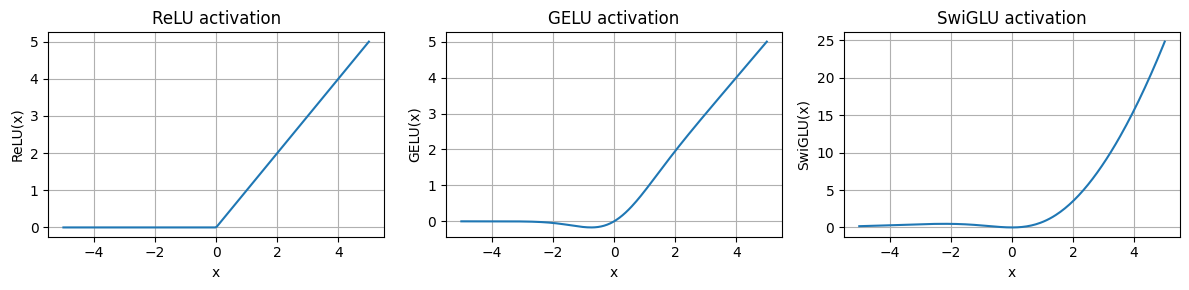

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class SwiGLU_Simple(nn.Module):
    def forward(self, x):
        return x * F.silu(x)

gelu = nn.GELU()
relu = nn.ReLU()
swiglu = SwiGLU_Simple()

x = torch.linspace(-5, 5, 200)

y_gelu = gelu(x)
y_relu = relu(x)
y_swiglu = swiglu(x)

plt.figure(figsize=(12, 3))
for i, (y, label) in enumerate(zip(
    [y_relu, y_gelu, y_swiglu], ["ReLU", "GELU", "SwiGLU"]), 1):
    plt.subplot(1, 3, i)
    plt.plot(x.numpy(), y.detach().numpy(), label=label)
    plt.title(f"{label} activation")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


### FeedForward with Gelu

In Transformers, the FFN is used after the attention mechanism to:
- Introduce nonlinearity: Attention is linear; FFN brings nonlinear learning capacity.
- Improve representation: Increases model depth and ability to model complex patterns.
- Operate per token: FFN acts on each token separately, without token-to-token interaction.

In [33]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), nn.GELU(), nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]))

    def forward(self, x):
        return self.layers(x)

print("model structure: \n",FeedForward(GPT_CONFIG_124M))

model structure: 
 FeedForward(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=3072, out_features=768, bias=True)
  )
)


### ShortCut connections


In [119]:
import torch
import torch.nn as nn

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList(nn.Sequential(nn.Linear(layer_sizes[i], layer_sizes[i+1]), nn.GELU()) for i in range(len(layer_sizes)-1))
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            out = layer(x)
            if self.use_shortcut and x.shape[-1] == out.shape[-1]:
                x = x + out
            else:
                x = out
        return x

def print_gradients(model,x):
    output = model(x)
    target = torch.zeros_like(output)
    loss = nn.MSELoss()(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        if param.grad is not None and 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [120]:
layer_sizes = [4] * 6

x = torch.randn(1, 4)

torch.manual_seed(123)
model = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print(model)
print_gradients(model, x)

ExampleDeepNeuralNetwork(
  (layers): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): GELU(approximate='none')
    )
  )
)
layers.0.0.weight has gradient mean of 3.108993041678332e-05
layers.1.0.weight has gradient mean of 7.357167487498373e-05
layers.2.0.weight has gradient mean of 0.0006941530737094581
layers.3.0.weight has gradient mean of 0.005131533369421959
layers.4.0.weight has gradient mean of 0.014868268743157387


In [124]:
layer_sizes = [4] * 6

x = torch.randn(1, 4)

torch.manual_seed(123)
model = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model, x)

layers.0.0.weight has gradient mean of 0.06876879185438156
layers.1.0.weight has gradient mean of 0.15942829847335815
layers.2.0.weight has gradient mean of 0.12936799228191376
layers.3.0.weight has gradient mean of 0.13758598268032074
layers.4.0.weight has gradient mean of 0.173927441239357


### Transformer

In [140]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_Q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_K = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_V = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_O = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
        self.register_buffer("mask", mask.bool())

    def forward(self, x):
        # shape (batch_size, seq_len, d_in)
        batch_size, seq_len, _ = x.size()

        # Split Q, K, V into multiple heads
        # (batch_size, seq_len, d_in) -> (batch_size, seq_len, d_out) ->
        # -> (batch_size, seq_len, num_heads, head_dim) -> (batch_size, num_heads, seq_len, head_dim)
        Q = self.W_Q(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_K(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_V(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        scores = Q @ K.transpose(-2, -1) / (self.d_out ** 0.5)  # (batch_size, num_heads, seq_len, seq_len)

        # Apply causal mask
        scores = scores.masked_fill(self.mask[:seq_len, :seq_len], -torch.inf)

        # Compute softmax weights and apply dropout
        weights = torch.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        # Compute output
        output = weights @ V  # (batch_size, num_heads, seq_len, head_dim)
        # Concatenate heads and project to output dimension
        # (batch_size, num_heads, seq_len, head_dim) -> (batch_size, seq_len, num_heads, head_dim)
        # ->   (batch_size, seq_len, d_out)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        # Should be helpful, but not strictly necessary.
        output = self.W_O(output)
        return output
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), nn.GELU(), nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]))

    def forward(self, x):
        return self.layers(x)
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(cfg["emb_dim"], cfg["emb_dim"], cfg["context_length"], cfg["drop_rate"], cfg["n_heads"], cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.ln1 = nn.LayerNorm(cfg["emb_dim"])
        self.ln2 = nn.LayerNorm(cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
        x = x + self.dropout(self.attn(self.ln1(x)))
        x = x + self.dropout(self.ff(self.ln2(x)))
        return x

In [141]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


### GPT2 model

In [142]:
import torch
import torch.nn as nn

class GPT2Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])

        self.blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = nn.LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, token_ids):
        batch_size, seq_len = token_ids.shape
        token_emb = self.token_emb(token_ids)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=token_ids.device))
        x = token_emb + pos_emb
        x = self.drop(x)
        x = self.blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [136]:
torch.manual_seed(123)
model = GPT2Model(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("Output shape:", out.shape)
print(out)

Input batch:
 tensor([[ 7454,  2402,   257,   640,   612],
        [22474,  1440,  1310, 22502,   896]])
Output shape: torch.Size([2, 5, 50257])
tensor([[[-0.5535,  0.4529, -0.4696,  ...,  0.3825, -0.1297, -1.1384],
         [ 0.3119, -1.2161, -0.4617,  ..., -0.3585,  0.1704,  0.0206],
         [ 1.5298, -0.1071,  0.5855,  ...,  0.1792, -0.0992,  0.1266],
         [-0.0482, -0.4500, -0.0636,  ...,  0.2731, -0.0906, -0.2470],
         [ 0.6004, -0.4716, -0.0837,  ...,  0.6402, -0.4540, -0.4408]],

        [[ 0.1923, -0.3315, -0.6307,  ..., -0.1130,  0.9947, -0.0477],
         [ 0.3393, -0.1646, -0.4265,  ..., -0.4938,  0.2773,  0.4487],
         [ 1.0538,  0.2296,  0.0455,  ...,  0.1404, -0.5532,  0.4073],
         [-0.6360, -1.0180, -0.2731,  ...,  0.9856, -0.8834, -0.5566],
         [ 0.7773, -0.1382, -0.1142,  ..., -0.2936, -0.7128, -0.4067]]],
       grad_fn=<UnsafeViewBackward0>)


In [143]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
GPT2Model                                --
├─Embedding: 1-1                         38,597,376
├─Embedding: 1-2                         786,432
├─Dropout: 1-3                           --
├─Sequential: 1-4                        --
│    └─TransformerBlock: 2-1             --
│    │    └─MultiHeadAttention: 3-1      2,360,064
│    │    └─FeedForward: 3-2             4,722,432
│    │    └─LayerNorm: 3-3               1,536
│    │    └─LayerNorm: 3-4               1,536
│    │    └─Dropout: 3-5                 --
│    └─TransformerBlock: 2-2             --
│    │    └─MultiHeadAttention: 3-6      2,360,064
│    │    └─FeedForward: 3-7             4,722,432
│    │    └─LayerNorm: 3-8               1,536
│    │    └─LayerNorm: 3-9               1,536
│    │    └─Dropout: 3-10                --
│    └─TransformerBlock: 2-3             --
│    │    └─MultiHeadAttention: 3-11     2,360,064
│    │    └─FeedForward: 3-12            4,722,432
│   

In [138]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

print("Token embedding layer shape:", model.token_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

total_size_mb = total_params * 4 / (1024 ** 2)
print(f"Total size of the model: {total_size_mb:.2f} MB")


Total number of parameters: 163,009,536
Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])
Number of trainable parameters considering weight tying: 124,412,160
Total size of the model: 621.83 MB


### Generate Text

In [147]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        # Get logits from model
        with torch.no_grad():
            logits = model(idx_cond)

        # Take logits for the last time step
        # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


In [144]:
def text_to_tensor(text,tokenizer):
    return torch.tensor(tokenizer.encode(text)).unsqueeze(0)

def tensor_to_text(tensor,tokenizer):
    return tokenizer.decode(tensor.squeeze(0).tolist())

encoded_tensor.shape: torch.Size([1, 5])
encoded_tensor: tensor([[7454, 2402,  257,  640,  612]])


In [148]:
start_context = "Once upon a time there"

encoded_tensor = text_to_tensor(start_context,tokenizer)
print("encoded_tensor.shape:", encoded_tensor.shape)
print("encoded_tensor:", encoded_tensor)

model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
decoded_text = tensor_to_text(out,tokenizer)
print(decoded_text)

encoded_tensor.shape: torch.Size([1, 5])
encoded_tensor: tensor([[7454, 2402,  257,  640,  612]])
Output: tensor([[ 7454,  2402,   257,   640,   612, 41117,  4683, 36413, 33205, 35780,
         22580]])
Once upon a time there discriminated existing REALLY JehovahQUEST valve
